In the final section we will attempt to model the `makes_prediction` variable using the features we devised earlier. This section will comprise:
1. data preprocessing for modelling purposes
1. modelling
1. model evaluation

We'll conclude with potential next steps to take the analysis futher.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame
import seaborn as sns

# data science utilities:
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# models:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from utilities import df_utils

RANDOM_STATE = 5

## Data preprocessing

We pick up where we left off in the feature engineering section: by importing the prepared features:

In [2]:
features = pd.read_csv('../data/features.csv', index_col=0)
df_utils.df_summarise(features)

(16599, 13)

Index(['customer_id', 'makes_purchase', 'last_transaction_date', 'recency',
       'recency_score', 'frequency', 'frequency_score', 'total_revenue',
       'total_revenue_score', 'rfm_score', 'rfm_segment', 'billing_zip_stem',
       'segment'],
      dtype='object')

,customer_id,makes_purchase,last_transaction_date,recency,recency_score,frequency,frequency_score,total_revenue,total_revenue_score,rfm_score,rfm_segment,billing_zip_stem,segment
0,3493717180478,0,2020-10-01 12:46:56,271,0,1,0,2445.00,2,2,low,87,3
1,3493777768510,0,2020-10-01 13:32:38,271,0,1,0,448.00,0,0,low,50,3
2,3490993078334,0,2020-10-01 13:38:06,271,0,1,0,2293.60,2,2,low,60,3
3,3433191145534,0,2020-10-01 14:28:48,271,0,1,0,438.95,0,0,low,28,3
4,3494350880830,0,2020-10-01 21:11:57,271,0,1,0,399.05,0,0,low,26,3


Before we use our features for model training we need to apply some basic preprocessing steps.

First of all, we will split our features into categorical and numerical. For categorical variables where there is no obvious ordering of the categories we will use one-hot encoding to represent the features:

In [3]:
categorical_cols = [
     'rfm_segment', 'billing_zip_stem', 'segment'
    ]
categorical_features = pd.get_dummies(
    features[categorical_cols].astype(str),
    )

It is worth noting that the ZIP code feature in particular has a siginficant (>100) number of categories. Creating a dummy variable out of it introduces sparsity to our model. Therefore tackling this could be among the next steps for our analysis - perhaps by using a different encoding scheme, encoding the values to a more compact latent space or extracting further location details.

As for the numerical features, we will standardise these to improve the numerical stability of the model. Note that we're considering the ordered clustering scores among the numerical variables since we established an ordinal relationship with the data:

In [4]:
numerical_cols = [
    'recency_score', 'frequency_score', 'total_revenue_score', 
    'rfm_score','recency', 'frequency', 'total_revenue'
    ]   
numerical_features = features[numerical_cols].copy()
normalised_features = preprocessing.normalize(numerical_features)
for idx, col in enumerate(numerical_cols):
    numerical_features[col] = normalised_features[:, idx]

Next we concatenate both feature sets:

In [5]:
model_features = pd.concat((
    numerical_features,
    categorical_features
    ), 
    axis=1)

df_utils.df_summarise(model_features)

(16599, 130)

Index(['recency_score', 'frequency_score', 'total_revenue_score', 'rfm_score',
       'recency', 'frequency', 'total_revenue', 'rfm_segment_high',
       'rfm_segment_low', 'rfm_segment_mid',
       ...
       'billing_zip_stem_VALBY', 'billing_zip_stem_nan', 'segment_1',
       'segment_10', 'segment_11', 'segment_3', 'segment_4', 'segment_6',
       'segment_7', 'segment_9'],
      dtype='object', length=130)

,recency_score,frequency_score,total_revenue_score,rfm_score,recency,frequency,total_revenue,rfm_segment_high,rfm_segment_low,rfm_segment_mid,...,billing_zip_stem_VALBY,billing_zip_stem_nan,segment_1,segment_10,segment_11,segment_3,segment_4,segment_6,segment_7,segment_9
0,0.0,0.0,0.000813,0.000813,0.110164,0.000407,0.993913,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.0,0.000000,0.000000,0.517581,0.001910,0.855632,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,0.000866,0.000866,0.117339,0.000433,0.993091,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,0.000000,0.000000,0.525329,0.001938,0.850897,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,0.000000,0.000000,0.561807,0.002073,0.827266,0,1,0,...,0,0,0,0,0,1,0,0,0,0


Lastly, we split the data into a training and validation set to make sure we can perform out-of-sample evaluation of the trained models:

In [6]:
train_features, val_features, train_target, val_target = train_test_split(
    model_features, 
    features['makes_purchase'], 
    test_size=0.2, 
    random_state=RANDOM_STATE
    )

## Model training

Now, we define the model suite we will be using for training purposes. As a starting point, we will be using the models out-of-the box without hyperparameter tuning:

In [7]:
models = {
    'logistic_regression': LogisticRegression(random_state=RANDOM_STATE),
    'naive_bayes': GaussianNB(),
    'CART': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'xgb': xgb.XGBClassifier(use_label_encoder=False),   
}

To choose the right architecutre for the job, we will train and evaluate the models using k-fold cross validation.

Since we are dealing with a highly imbalanced dataset, we will be using the F1 score to evaluate the models:

In [8]:
for model_name, model in models.items():
    kfold = KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
    result = cross_val_score(model, train_features, train_target, cv=kfold, scoring='f1')
    print(model_name, result, f'average score: {np.mean(result):.1%}')

logistic_regression [0.         0.07407407 0.03773585] average score: 3.7%
naive_bayes [0.02042711 0.02524383 0.02121855] average score: 2.2%
CART [0.23684211 0.3853211  0.19047619] average score: 27.1%
random_forest [0.16949153 0.10526316 0.10169492] average score: 12.5%
[22:36:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:36:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

Training on the imbalanced dataset spawns rather poor results - the best score of 30% F1 can hardly be considered a good evaluation result.

The results of the XGBoost model look most promising out of the bunch - and small wonder, since xgboost is still considered state-of-the-art with regards to tabular data problems. We will attempt a basic hyperparameter tuning for xgboost using grid search:

In [9]:
parameters = {
    'max_depth': range(3, 8, 2),
    'booster': ['gbtree', 'gblinear'],
    'min_child_weight': range(1, 6, 2),
    'lambda': [1, 2],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=parameters,
    scoring='f1',
    n_jobs=-1,
    cv=2
    )

grid_search.fit(train_features, train_target)
grid_search.best_params_, grid_search.best_score_

/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:42:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'booster': 'gbtree', 'lambda': 1, 'max_depth': 7, 'min_child_weight': 5},
 0.30973671137605563)

Grid search did not result in a significant improvement over the default hyperparameters:

## Upsampling

One of the possible approaches to battle the severe class imbalance that we have in the dataset is using a sampling scheme - either oversampling or undersampling. For this excercise, we will use the Synthetic Minority Oversampling Technique (or SMOTE) to oversample the minority class. 

We could opt for using a simple oversampling scheme where we simply use minority class examples more than once but using SMOTE has the additional benefit of introducing some variation to the upsampled data.

In [10]:
smote = SMOTE(random_state=RANDOM_STATE)
upsampled_train_features, upsampled_train_target = smote.fit_resample(train_features, train_target)
upsampled_train_features.shape, upsampled_train_target.shape

((26258, 130), (26258,))

We train the models again, this time on the upsampled dataset. We will not be using k-fold crossvalidation, since by upsampling we intoduce a level of data leakage into our dataset. Instead, we will compare the models using their performance on the out-of-sample validation set - again using the F1 score:

In [11]:
for model_name, model in models.items():
    kfold = KFold(n_splits=4, random_state=RANDOM_STATE, shuffle=True)
    trained_model = model.fit(upsampled_train_features, upsampled_train_target)
    val_predictions = trained_model.predict(val_features)
    score = f1_score(val_target, val_predictions)
    print(model_name, f'f1 val score: {score:.1%}')

/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logistic_regression f1 val score: 18.4%
naive_bayes f1 val score: 2.3%
CART f1 val score: 16.9%
random_forest f1 val score: 33.8%
[22:43:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb f1 val score: 30.3%


Upsampling has significantly improved the results of the random forest classifier and gave it a minor margin over the xgboost model. Therefore we will use it for the final evaluation.

## Evaluation

In [12]:
model = RandomForestClassifier(random_state=RANDOM_STATE).fit(upsampled_train_features, upsampled_train_target)
val_predictions = model.predict(val_features)
f1_score(val_target, val_predictions)

0.3384615384615385

Let's review the validation confusion matrix to better understand the quality of our predictions:

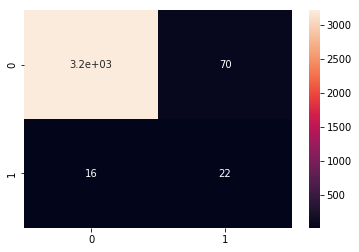

In [13]:
sns.heatmap(confusion_matrix(val_target, val_predictions), annot=True);

Looks like the model is making a significant number of false positive predictions - roughly twice the amount of all positive ground truth examples. It is likely the upsampling scheme is not enough to battle the significant imbalance as there might not be enough positive examples in our dataset.

Also, this is also most likely a result of improper feature engineering. To see how good our engineered features fared, let's review the feature importance.

**Feature importance**

First let's define a helper function to display and plot the results of feature importance:

In [14]:
def show_feature_importance(
        feature_importances: ndarray, 
        model_features: DataFrame, 
        top_features: int = 10
        ) -> None:
    """
    Displays feature importance results
    """
    mapped_feature_importances = [
        (feature_name, feature_importance ) 
        for feature_name, feature_importance in zip(model_features.columns, feature_importances)
        ]
    sorted_feature_importances = sorted(mapped_feature_importances, key=lambda x: x[1], reverse=True)[:top_features]

    for feature_name, feature_score in sorted_feature_importances:
        print(f'{feature_name}: {feature_score:.2f}')

    top_feature_names = [feature[0] for feature in sorted_feature_importances]
    top_feature_scores = [feature[1] for feature in sorted_feature_importances]

    plt.figure(figsize=(20,10))
    plt.barh(range(len(top_feature_scores)), top_feature_scores)
    plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
    plt.show()

Next, we can review the in-built feature importances of the random forest model based on Gini impurity:

segment_3: 0.20
segment_11: 0.14
rfm_score: 0.07
recency_score: 0.07
segment_1: 0.07
frequency_score: 0.06
total_revenue: 0.06
recency: 0.05
frequency: 0.05
segment_6: 0.03


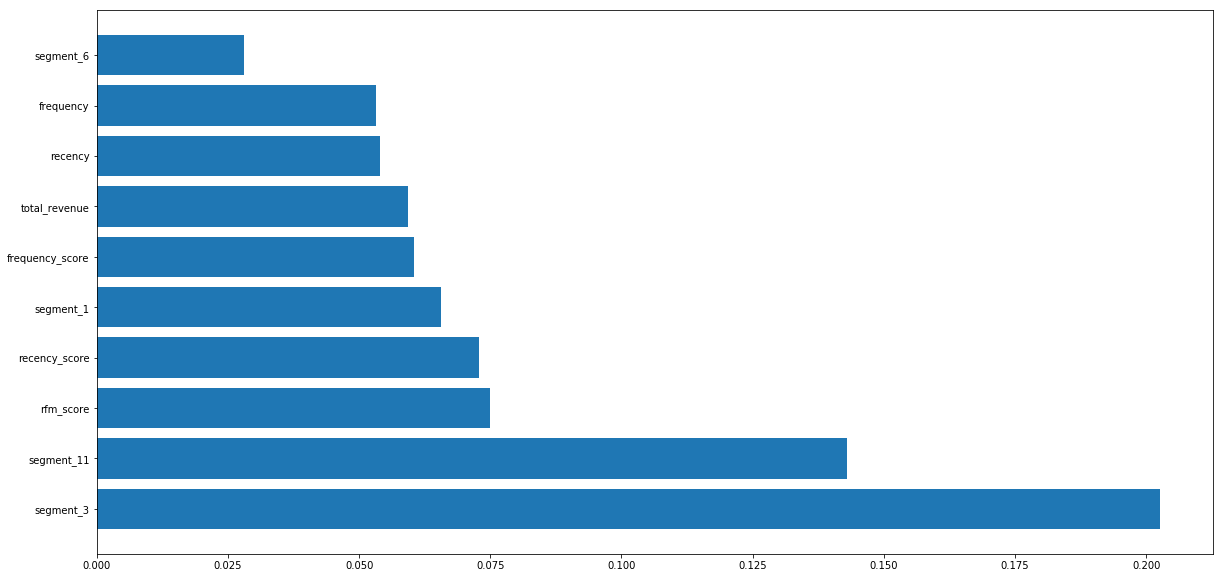

In [15]:
feature_importances = model.feature_importances_
show_feature_importance(feature_importances, model_features)

Looks like the original `segment` features seem to be playing the most important role. Out of the features devised by us earlier, `rfm_score` and `recency_score` stand out, which is intuitive.

To complete the picture, we'll use another feature importance estimation method called permutation score - this one is agnostic of the model architecture used.

segment_3: 0.29
segment_1: 0.23
frequency_score: 0.17
segment_6: 0.14
total_revenue: 0.12
segment_11: 0.10
recency: 0.07
rfm_segment_high: 0.04
recency_score: 0.04
total_revenue_score: 0.03


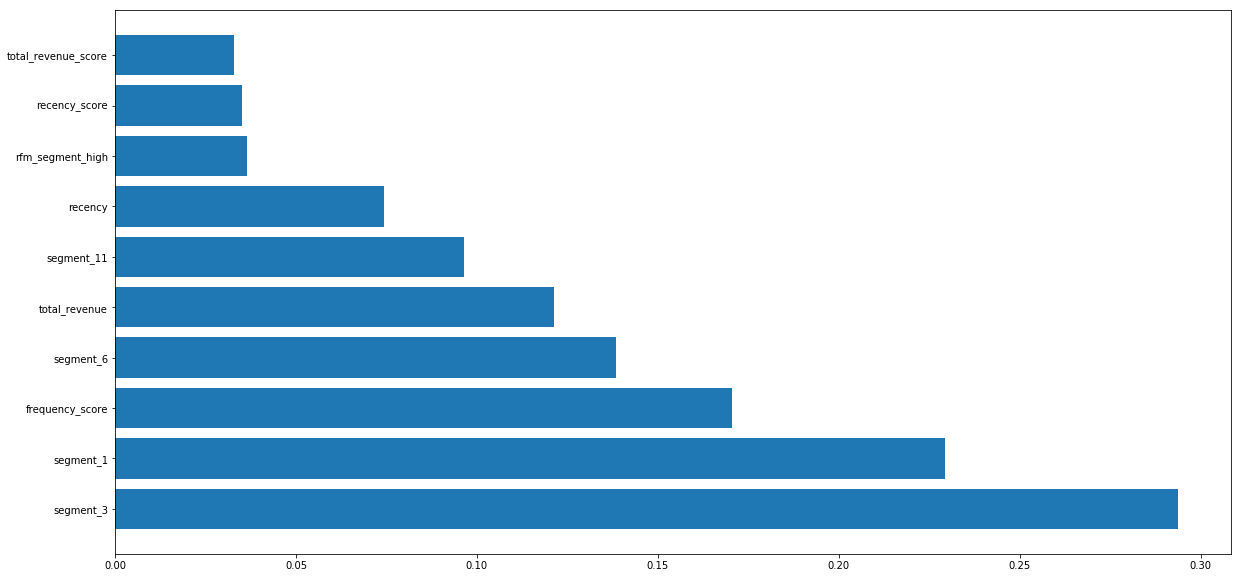

In [16]:
results = permutation_importance(model, val_features, val_target, scoring='f1')
feature_importances = results.importances_mean
show_feature_importance(feature_importances, model_features)

Our earlier observations of `segment` based features playing the most important role are confirmed. This time around though, `frequency_score` has the most effect on our target score.

## Potential next steps

As shown above, our features and modelling approach spawns results that can certainly still be improved. Among possible next steps we could consider:

* further feature engineering to identify features with higher correlation with the target variable. Especially exploring the possibilities of enhancing the `segment` variable seem reasonable
* improvements in the data preprocessing stage, in particular in handling high dimensional categorical variables
* using a different modelling approach: since the majority class is so significantly dominant, perhaps using outlier detection techniques (e.g. autoencoders, DBSCAN, isolation forest)